# Kmean - Algorithm

<b> Step 1: </b> Random Centriods <br>
<b> Step 2: </b> Label data points <br>
<b> Step 3: </b> Recalculated the new Centroids

Repeat 2)-3) if the new centroid have changed postions <br>
Stop when centroids remain the same

# Preparation

import ไลบรารี่ที่จำเป็น

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Read datasets: created with 3 different Gaussian distributions (3 classes)

Preprocess: Clean data, calculate Log Returns
ล้างข้อมูล (เช่น ลบ NaN, ตรวจชนิดข้อมูล) และคำนวณค่าผลตอบแทนแบบลอการิทึม (Log Return) ซึ่งช่วยลดความแปรปรวนและแสดงการเปลี่ยนแปลงของราคาอย่างแม่นยำ

In [ ]:
import pandas as pd
import numpy as np

# โหลดไฟล์ Excel
xls = pd.ExcelFile("/content/Healthcare_stocks_cleaned.xlsx")

# รายชื่อหุ้น (ชื่อ sheet)
tickers = xls.sheet_names

# ดึงข้อมูลของแต่ละหุ้นเก็บไว้
data_dict = {}

for ticker in tickers:
    df = xls.parse(ticker)

    # แปลง Date เป็น datetime และตั้งเป็น index
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')  # ป้องกัน error
    df.dropna(subset=["Date"], inplace=True)
    df.set_index("Date", inplace=True)

    # ตรวจสอบชนิดข้อมูล และแปลงเป็นตัวเลขถ้าจำเป็น
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")

    # ลบค่า missing
    df.dropna(subset=["Close"], inplace=True)



    # เก็บไว้ใน dict
    data_dict[ticker] = df

In [ ]:
print(xls.sheet_names)

['ABT', 'ABBV', 'A', 'ALGN', 'AMGN', 'BAX', 'BDX', 'TECH', 'BIIB', 'BSX', 'BMY', 'CAH', 'COR', 'CNC', 'CRL', 'CI', 'COO', 'CVS', 'DHR', 'DVA', 'DXCM', 'EW', 'ELV', 'GEHC', 'GILD', 'HCA', 'HSIC', 'HOLX', 'HUM', 'IDXX', 'INCY', 'PODD', 'ISRG', 'IQV', 'JNJ', 'LH', 'LLY', 'MCK', 'MDT', 'MRK', 'MTD', 'MRNA', 'MOH', 'PFE', 'DGX', 'REGN', 'RMD', 'RVTY', 'SOLV', 'STE', 'SYK', 'TMO', 'UNH', 'UHS', 'VRTX', 'VTRS', 'WAT', 'WST', 'ZBH', 'ZTS']


In [ ]:
df = pd.read_excel("/content/Healthcare_stocks_cleaned.xlsx", index_col = 0, parse_dates= True)
type(df)

pandas.core.frame.DataFrame

สำเนาข้อมูล จาก DataFrame df มาเก็บในตัวแปร stock (เพื่อป้องกันไม่ให้ข้อมูลต้นฉบับเปลี่ยนแปลงเวลาแก้ไขหรือวิเคราะห์ต่อ)

แสดง 5 แถวแรก ของ DataFrame stock โดยใช้ .head() เพื่อดูข้อมูลเบื้องต้น

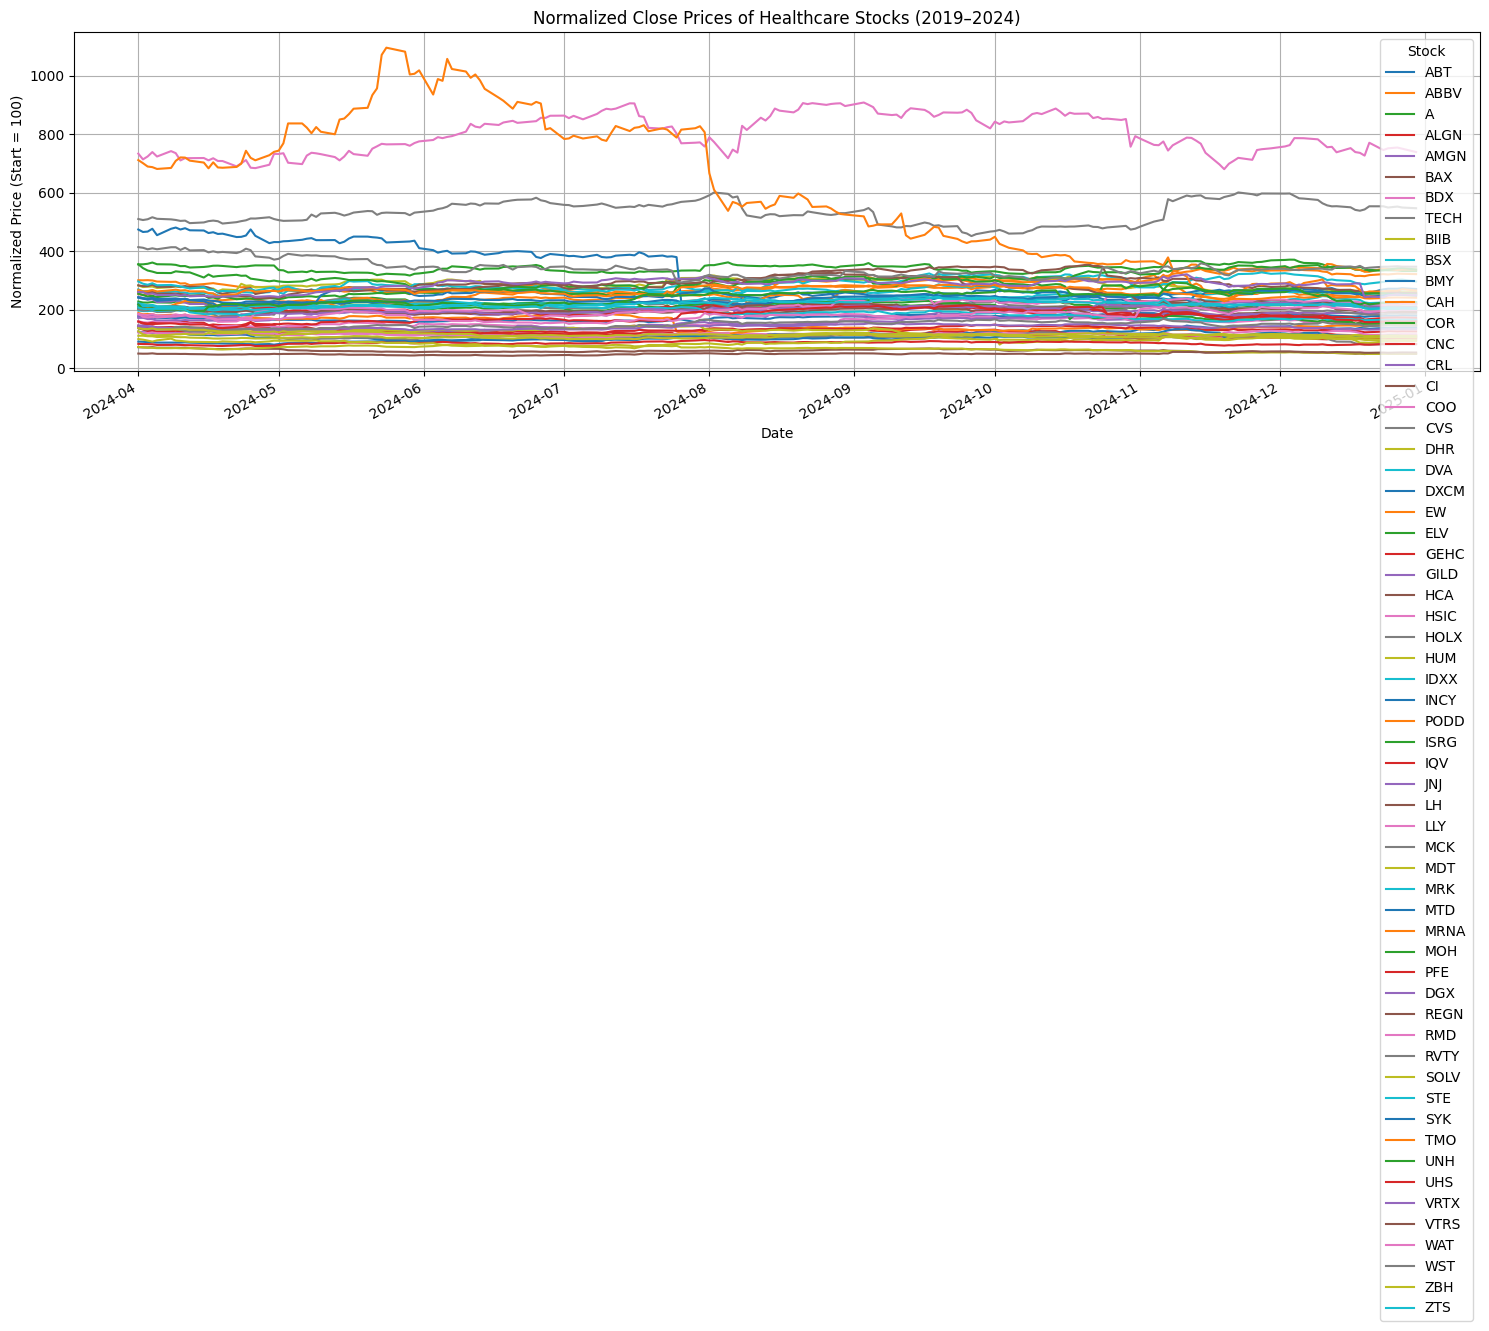

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# โหลดไฟล์ Excel
xls = pd.ExcelFile("/content/Healthcare_stocks_cleaned.xlsx")
tickers = xls.sheet_names

# เก็บราคาที่ normalize แล้ว
normalized_df = pd.DataFrame()

for ticker in tickers:
    df = xls.parse(ticker)

    # แปลงคอลัมน์วันที่
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
    df.dropna(subset=["Date"], inplace=True)
    df.set_index("Date", inplace=True)

    # แปลง Close เป็นตัวเลข
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    df.dropna(subset=["Close"], inplace=True)

    # กรองเฉพาะช่วง 2019–2024
    df = df[(df.index >= '2019-01-01') & (df.index <= '2024-12-31')]

    # ข้ามถ้าไม่มีข้อมูลในช่วงนี้
    if df.empty:
        continue

    # Normalize โดยให้ราคาวันแรก = 100
    normalized_price = df["Close"] / df["Close"].iloc[0] * 100

    # รวมเข้า DataFrame หลัก
    normalized_df[ticker] = normalized_price

# ลบ NaN (หุ้นบางตัวอาจไม่มีข้อมูลวันเดียวกัน)
normalized_df.dropna(inplace=True)

# พล็อตกราฟ
plt.figure(figsize=(15, 10))
normalized_df.plot(ax=plt.gca(), title='Normalized Close Prices of Healthcare Stocks (2019–2024)')
plt.xlabel("Date")
plt.ylabel("Normalized Price (Start = 100)")
plt.grid(True)
plt.legend(title="Stock")
plt.tight_layout()
plt.show()


In [ ]:
stock = df.copy()
stock.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,62.043289,63.346644,61.659424,62.837800,8737200
2019-01-03,59.115192,61.489795,58.472441,61.364816,10570700
2019-01-04,60.802406,61.221981,59.802570,59.918626,8299100
2019-01-07,61.712967,62.364647,60.864896,60.873825,9503000
2019-01-08,60.972034,62.168261,59.811510,62.087921,8905100


Calculate Features: Mean Log Return, Volatility
สร้างฟีเจอร์สำคัญ 2 ตัว:

ค่าผลตอบแทนเฉลี่ย (Mean Log Return)

ความผันผวนของผลตอบแทน (Volatility)



In [ ]:
data_dict

{'ABT':                   Open        High         Low       Close    Volume
 Date                                                                
 2019-01-02   62.043289   63.346644   61.659424   62.837800   8737200
 2019-01-03   59.115192   61.489795   58.472441   61.364816  10570700
 2019-01-04   60.802406   61.221981   59.802570   59.918626   8299100
 2019-01-07   61.712967   62.364647   60.864896   60.873825   9503000
 2019-01-08   60.972034   62.168261   59.811510   62.087921   8905100
 ...                ...         ...         ...         ...       ...
 2024-12-23  113.188957  113.387000  111.852198  112.882000   4028200
 2024-12-24  113.634544  113.703858  112.476013  113.020622   1480000
 2024-12-26  114.139534  114.674239  112.703757  113.080028   2960500
 2024-12-27  113.862289  114.812874  113.387001  113.882098   2829500
 2024-12-30  111.693764  113.515715  111.416503  113.010715   3475800
 
 [1509 rows x 5 columns],
 'ABBV':                   Open        High         Low

In [ ]:
import pandas as pd
import numpy as np
feature_rows = []


for ticker in xls.sheet_names:
    df = xls.parse(ticker)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

    df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))
    df.dropna(subset=["LogReturn"], inplace=True)

    mean_log_ret = df["LogReturn"].mean()
    std_log_ret = df["LogReturn"].std()

    # เก็บเป็น dictionary แล้วใส่ใน list
    feature_rows.append({
        "Ticker": ticker,
        "MeanLogReturn": mean_log_ret,
        "Volatility": std_log_ret
    })

# แปลง list เป็น DataFrame ทีเดียว
features = pd.DataFrame(feature_rows)

# แสดงผล
print(features.head())


  Ticker  MeanLogReturn  Volatility
0   AAPL       0.001000    0.020212
1    ACN       0.000468    0.018032
2   ADBE       0.000234    0.023659
3    ADI       0.000534    0.020467
4   ADSK       0.000369    0.024292


# **Standardize Features**
ทำการสเกลข้อมูลให้มีค่าเฉลี่ย = 0 และส่วนเบี่ยงเบนมาตรฐาน = 1 เพื่อให้โมเดลไม่ Bias จากขนาดของฟีเจอร์

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

feature_rows = []

for ticker in xls.sheet_names:
    df = xls.parse(ticker)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

    df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))
    df.dropna(subset=["LogReturn"], inplace=True)

    mean_log_ret = df["LogReturn"].mean()
    std_log_ret = df["LogReturn"].std()

    feature_rows.append({
        "Ticker": ticker,
        "MeanLogReturn": mean_log_ret,
        "Volatility": std_log_ret
    })

features = pd.DataFrame(feature_rows)

# Standardize Features
scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[['MeanLogReturn', 'Volatility']] = scaler.fit_transform(features[['MeanLogReturn', 'Volatility']])

print(features_scaled.head())


  Ticker  MeanLogReturn  Volatility
0   AAPL       0.593535   -0.685768
1    ACN      -0.408496   -1.002518
2   ADBE      -0.847917   -0.184902
3    ADI      -0.284921   -0.648668
4   ADSK      -0.593640   -0.093038


In [ ]:
print(features.isna().sum())


Ticker           0
MeanLogReturn    0
Volatility       0
dtype: int64


In [ ]:
features.describe()

,MeanLogReturn,Volatility
count,69.000000,69.000000
mean,0.000685,0.024932
std,0.000535,0.006933
min,-0.000778,0.015716
25%,0.000368,0.019930
50%,0.000570,0.023925
75%,0.000969,0.027201
max,0.002485,0.048308


# ***ตีความข้อมูล***
ข้อมูลฟีเจอร์ประกอบด้วย MeanLogReturn และ Volatility ของหุ้นกลุ่มเทคโนโลยีจำนวน 69 ตัว

ค่าเฉลี่ยของ MeanLogReturn อยู่ที่ประมาณ 0.000685 แสดงว่าหุ้นโดยเฉลี่ยมีผลตอบแทนรายวันเล็กน้อยในเชิงบวก

Volatility มีค่าเฉลี่ยประมาณ 0.0249 หมายถึงความผันผวนของผลตอบแทนโดยเฉลี่ยอยู่ในระดับ 2.5% ต่อวัน

ค่าความแปรปรวน (std) ของทั้งสองฟีเจอร์บอกถึงการกระจายตัวของข้อมูล โดย Volatility มีความแปรปรวนสูงกว่าค่าเฉลี่ยมากกว่า MeanLogReturn

ค่าต่ำสุดและค่าสูงสุดแสดงช่วงกว้างของข้อมูล เช่น MeanLogReturn ต่ำสุดติดลบ -0.000778 และสูงสุด 0.002485 ส่วน Volatility ต่ำสุด 0.0157 สูงสุด 0.0483

ทำไมต้อง Standardize Features
เนื่องจากค่าของ MeanLogReturn และ Volatility อยู่ในสเกลที่แตกต่างกันมาก (เช่น 0.0006 กับ 0.02) หากนำไปใช้กับโมเดล K-Means หรือ Machine Learning อื่น ๆ ที่วัดระยะห่างโดยใช้มาตรฐาน Euclidean distance จะทำให้ฟีเจอร์ที่มีขนาดใหญ่กว่าครอบงำการวัดระยะ และทำให้โมเดลเกิดความลำเอียง (bias) ได้

ดังนั้น เราจึงทำการ Standardize คือ

ปรับให้แต่ละฟีเจอร์มีค่าเฉลี่ย (mean) เป็น 0

และส่วนเบี่ยงเบนมาตรฐาน (standard deviation) เป็น 1

วิธีนี้ช่วยให้ฟีเจอร์ทั้งหมดมีความสำคัญเท่าเทียมกันเมื่อคำนวณระยะห่าง และช่วยเพิ่มประสิทธิภาพและความถูกต้องของโมเดล

Standardize Features
ทำการสเกลข้อมูลให้มีค่าเฉลี่ย = 0 และส่วนเบี่ยงเบนมาตรฐาน = 1 เพื่อให้โมเดลไม่ลำเอียงจากขนาดของฟีเจอร์

Apply K-Means Clustering
ใช้อัลกอริทึม K-Means เพื่อจัดกลุ่มหุ้นตามพฤติกรรมผลตอบแทนและความผันผวนที่คล้ายกัน



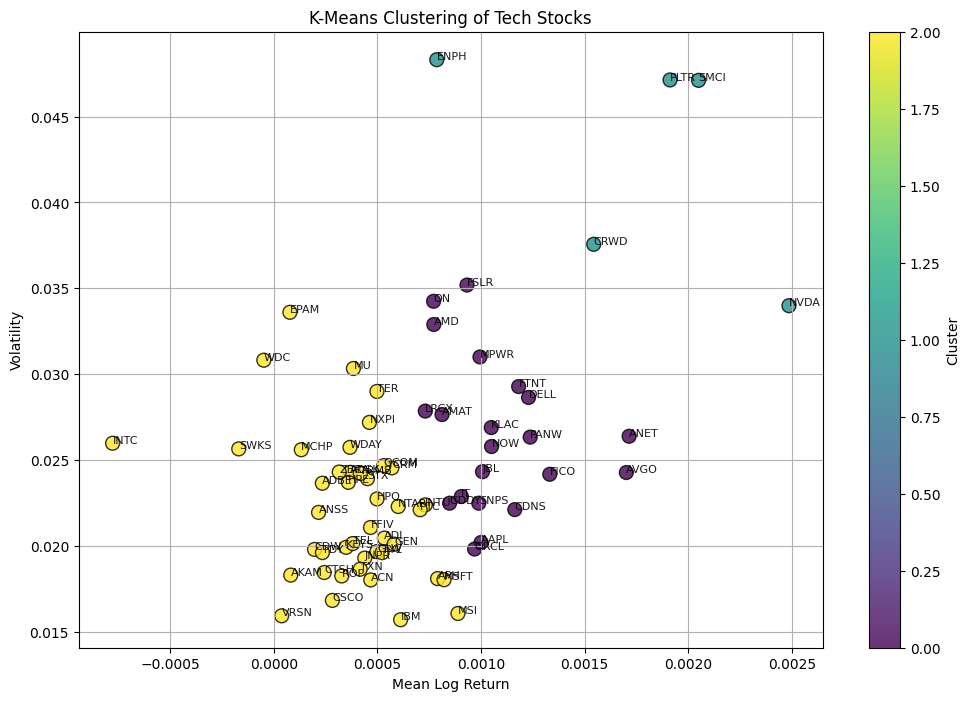

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# เตรียมข้อมูล X จาก features
X1 = features['MeanLogReturn'].values
X2 = features['Volatility'].values
X = np.array(list(zip(X1, X2)))

# สเกลข้อมูลก่อนทำ K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ทำ K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
features['Cluster'] = clusters

# พล็อตกราฟพร้อมสีตาม Cluster
plt.figure(figsize=(12,8))
scatter = plt.scatter(features['MeanLogReturn'], features['Volatility'],
                      c=features['Cluster'], cmap='viridis', s=100, edgecolors='k', alpha=0.8)

# แสดงชื่อหุ้น (annotation)
for i, row in features.iterrows():
    plt.text(row['MeanLogReturn'], row['Volatility'], row['Ticker'], fontsize=8, alpha=0.9)

plt.xlabel('Mean Log Return')
plt.ylabel('Volatility')
plt.title('K-Means Clustering of Tech Stocks')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()


In [ ]:
print(features)

   Ticker  MeanLogReturn  Volatility  Cluster
0    AAPL       0.001000    0.020212        0
1     ACN       0.000468    0.018032        2
2    ADBE       0.000234    0.023659        2
3     ADI       0.000534    0.020467        2
4    ADSK       0.000369    0.024292        2
..    ...            ...         ...      ...
64    TYL       0.000523    0.019618        2
65   VRSN       0.000038    0.015944        2
66   WDAY       0.000368    0.025748        2
67    WDC      -0.000048    0.030820        2
68   ZBRA       0.000316    0.024312        2

[69 rows x 4 columns]


In [ ]:
# ส่งออกไฟล์ Excel พร้อมข้อมูล Cluster
features.to_excel("clustered_tech_stocks.xlsx", index=False)

print("ส่งออกไฟล์ clustered_tech_stocks.xlsx เรียบร้อยแล้ว")


ส่งออกไฟล์ clustered_tech_stocks.xlsx เรียบร้อยแล้ว


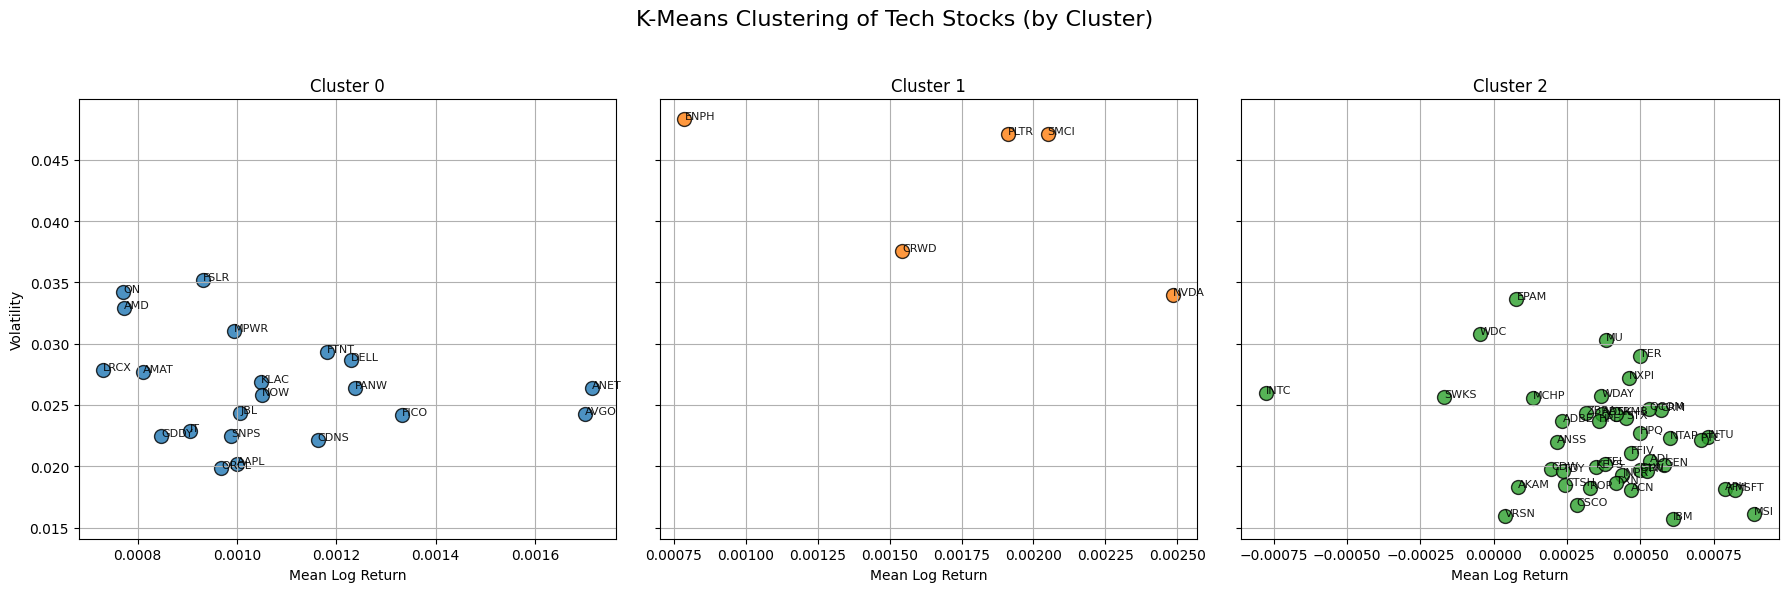

In [ ]:
import matplotlib.pyplot as plt

# กำหนดสีแต่ละคลัสเตอร์ (สามารถปรับได้)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
cluster_labels = sorted(features['Cluster'].unique())
num_clusters = len(cluster_labels)

# สร้าง subplot
fig, axes = plt.subplots(1, num_clusters, figsize=(6 * num_clusters, 6), sharey=True)

if num_clusters == 1:
    axes = [axes]  # ถ้ามีคลัสเตอร์เดียว

for i, cluster in enumerate(cluster_labels):
    ax = axes[i]
    cluster_data = features[features['Cluster'] == cluster]

    ax.scatter(cluster_data['MeanLogReturn'], cluster_data['Volatility'],
               color=colors[i % len(colors)], s=100, edgecolors='k', alpha=0.8)

    for _, row in cluster_data.iterrows():
        ax.text(row['MeanLogReturn'], row['Volatility'], row['Ticker'], fontsize=8, alpha=0.9)

    ax.set_title(f"Cluster {cluster}")
    ax.set_xlabel("Mean Log Return")
    if i == 0:
        ax.set_ylabel("Volatility")
    ax.grid(True)

plt.suptitle("K-Means Clustering of Tech Stocks (by Cluster)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



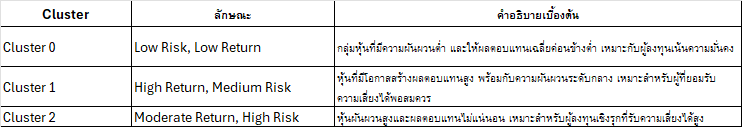

# ***  วิธีเลือก “หุ้นตัวแทน” จากแต่ละคลัสเตอร์  เลือกหุ้นที่ “ใกล้จุดศูนย์กลางคลัสเตอร์มากที่สุด  คำนวณระยะห่างจากแต่ละจุด (หุ้น) ไปยัง centroid ของคลัสเตอร์นั้น ๆ***

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min

# หา centroid ของแต่ละคลัสเตอร์
centroids = kmeans.cluster_centers_

# หา index ของหุ้นที่ใกล้ centroid ที่สุดในแต่ละคลัสเตอร์
closest, _ = pairwise_distances_argmin_min(centroids, X_scaled)

# แสดงหุ้นตัวแทน
representatives = features.iloc[closest]
print(representatives[['Ticker', 'Cluster']])


   Ticker  Cluster
37   KLAC        0
51   PLTR        1
21   FFIV        2


 วิธีที่ 2: เลือกหุ้นที่มี “ขนาดกลาง” (ค่ากลาง)
ใช้ median หรือ average ของ MeanLogReturn และ Volatility ภายในกลุ่ม

เลือกหุ้นที่ค่าฟีเจอร์ใกล้ค่า median มากที่สุด

# ขั้นตอน: เลือกหุ้นที่ใกล้ค่ากลางของคลัสเตอร์ (Median-Based Representative) คำนวณ median ของ MeanLogReturn และ median ของ Volatility


# ***คำนวณ ระยะห่าง (Euclidean distance) ***

In [ ]:
import numpy as np

representatives = []

# วนลูปในแต่ละคลัสเตอร์
for cluster in sorted(features['Cluster'].unique()):
    cluster_data = features[features['Cluster'] == cluster]

    # ค่ากลางของฟีเจอร์ในคลัสเตอร์
    median_log_ret = cluster_data['MeanLogReturn'].median()
    median_vol = cluster_data['Volatility'].median()

    # คำนวณระยะห่างจากค่ากลาง
    distances = np.sqrt(
        (cluster_data['MeanLogReturn'] - median_log_ret)**2 +
        (cluster_data['Volatility'] - median_vol)**2
    )

    # เลือกหุ้นที่ใกล้ค่ากลางที่สุด
    representative_idx = distances.idxmin()
    representatives.append(features.loc[representative_idx])

# แสดงหุ้นตัวแทนแต่ละกลุ่ม
representative_df = pd.DataFrame(representatives)
print(representative_df[['Ticker', 'Cluster', 'MeanLogReturn', 'Volatility']])


   Ticker  Cluster  MeanLogReturn  Volatility
50   PANW        0       0.001237    0.026344
51   PLTR        1       0.001912    0.047132
9    ANSS        2       0.000216    0.021962


# ***📌 วิธีเลือก “หุ้นตัวแทน” จากแต่ละคลัสเตอร์***
✅ วิธีที่ 1: เลือกหุ้นที่ใกล้ Centroid ของคลัสเตอร์มากที่สุด
ใช้ Euclidean Distance จากจุด (MeanLogReturn, Volatility) ไปยัง Centroid ของคลัสเตอร์

หุ้นที่มีระยะห่างน้อยที่สุด = ตัวแทนของกลุ่มนั้น

เหมาะสำหรับการจำลองลักษณะ "โดยรวม" ของกลุ่ม (เป็นค่าเฉลี่ยแบบรวมทุกมิติ)

📋 หุ้นตัวแทนที่ได้ (ใกล้ Centroid ที่สุด): Cluster	Ticker


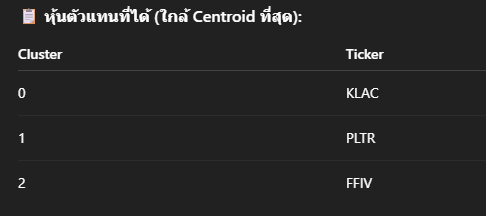



✅ วิธีที่ 2: เลือกหุ้นที่ใกล้ "ค่ากลาง (Median)" ของฟีเจอร์ในคลัสเตอร์
คำนวณ Median ของ MeanLogReturn และ Median ของ Volatility ภายในคลัสเตอร์

คำนวณ Euclidean Distance ระหว่างหุ้นแต่ละตัวกับตำแหน่ง (median, median)

เลือกตัวที่ใกล้ที่สุด = ตัวแทนของกลุ่มในเชิงค่ากลาง

เหมาะสำหรับการวิเคราะห์หุ้นที่เป็น "กลาง" ของกลุ่ม (ไม่สุดโต่ง)

📋 หุ้นตัวแทนที่ได้ (ใกล้ Median ที่สุด):


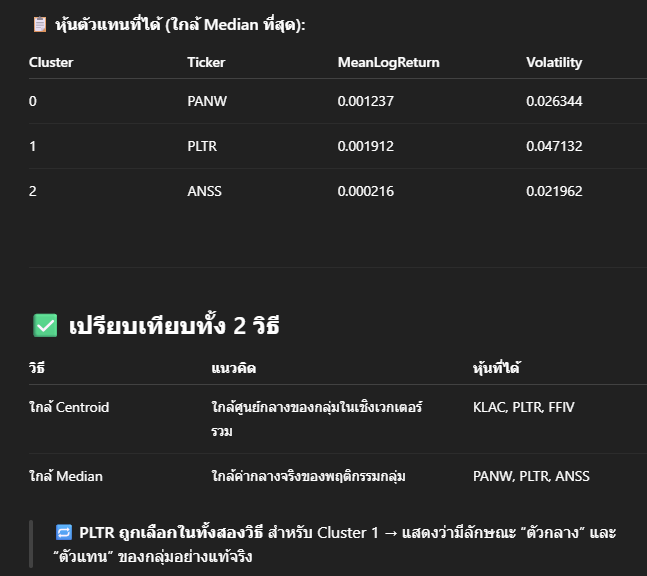


✅ เปรียบเทียบทั้ง 2 วิธี
วิธี	แนวคิด	หุ้นที่ได้
ใกล้ Centroid	ใกล้ศูนย์กลางของกลุ่มในเชิงเวกเตอร์รวม	KLAC, PLTR, FFIV
ใกล้ Median	ใกล้ค่ากลางจริงของพฤติกรรมกลุ่ม	PANW, PLTR, ANSS

🔁 PLTR ถูกเลือกในทั้งสองวิธี สำหรับ Cluster 1 → แสดงว่ามีลักษณะ “ตัวกลาง” และ “ตัวแทน” ของกลุ่มอย่างแท้จริง

In [ ]:
# 1. เตรียมข้อมูลสำหรับทำ K-Means

import numpy as np

X = np.array(list(zip(features['MeanLogReturn'], features['Volatility'])))


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)


In [ ]:
features['Cluster'] = clusters


In [ ]:
print(features.head())


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(features['MeanLogReturn'], features['Volatility'], c=features['Cluster'], cmap='viridis', s=100, edgecolors='k')
plt.xlabel('Mean Log Return')
plt.ylabel('Volatility')
plt.title('K-Means Clustering')
plt.grid(True)
plt.show()


7. วิเคราะห์ผลลัพธ์จาก Cluster
ดูว่าแต่ละกลุ่ม (Cluster) มีลักษณะยังไง

เช่น กลุ่มไหนความเสี่ยงสูง ผลตอบแทนสูง กลุ่มไหนความเสี่ยงต่ำ ผลตอบแทนต่ำ

จะช่วยให้คุณเลือกหุ้นหรือตั้งกลยุทธ์ลงทุนตามกลุ่มได้

In [ ]:
for c in features['Cluster'].unique():
    print(f"Cluster {c}:")
    print(features[features['Cluster'] == c][['MeanLogReturn', 'Volatility']].describe())
    print()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
scatter = plt.scatter(features['MeanLogReturn'], features['Volatility'],
                      c=features['Cluster'], cmap='viridis', s=100, edgecolors='k', alpha=0.8)

for i, row in features.iterrows():
    plt.text(row['MeanLogReturn'], row['Volatility'], row['Ticker'], fontsize=8, alpha=0.9)

plt.xlabel('Mean Log Return')
plt.ylabel('Volatility')
plt.title('K-Means Clustering of Tech Stocks')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()


In [ ]:
for c in features['Cluster'].unique():
    print(f"Cluster {c} summary:")
    print(features[features['Cluster'] == c][['MeanLogReturn', 'Volatility']].describe())
    print()


In [ ]:
features.to_excel("tech_stocks_clustered.xlsx", index=False)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

X = np.array(list(zip(features['MeanLogReturn'], features['Volatility'])))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for k in [2, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    features['Cluster'] = clusters

    print(f"===== Results for k = {k} =====")
    print(features.groupby('Cluster')[['MeanLogReturn', 'Volatility']].mean())
    print()

    plt.figure(figsize=(8,5))
    scatter = plt.scatter(features['MeanLogReturn'], features['Volatility'],
                          c=features['Cluster'], cmap='viridis', s=100, edgecolors='k', alpha=0.8)
    plt.xlabel('Mean Log Return')
    plt.ylabel('Volatility')
    plt.title(f'K-Means Clustering (k={k})')
    plt.grid(True)
    plt.colorbar(scatter, label='Cluster')
    plt.show()


In [ ]:
kmeans = KMeans(n_clusters=3, max_iter=300, tol=1e-4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)


In [ ]:
import numpy as np

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def kmeans_manual(X, k, max_iters=100, tol=1e-4):
    np.random.seed(42)
    centroids = X[np.random.choice(len(X), k, replace=False)]

    for i in range(max_iters):
        clusters = []
        for x in X:
            distances = [euclidean_distance(x, c) for c in centroids]
            clusters.append(np.argmin(distances))
        clusters = np.array(clusters)

        new_centroids = np.array([X[clusters == i].mean(axis=0) for i in range(k)])

        # ถ้า centroids ไม่เปลี่ยนแปลงเกิน tol หยุด loop
        if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < tol):
            print(f"Converged at iteration {i+1}")
            break
        centroids = new_centroids

    return clusters, centroids

# ใช้งาน
clusters, centroids = kmeans_manual(X_scaled, k=3)


In [ ]:
print(len(tickers))  # ต้องเท่ากับ 69
print(len(features)) # ต้องเท่ากับ 69


In [ ]:
tickers = xls.sheet_names  # สมมติใช้ xls = pd.ExcelFile('ไฟล์ของคุณ.xlsx')


In [ ]:
features['Ticker'] = tickers


In [ ]:
import pandas as pd

# สมมติคุณมีชื่อหุ้นในตัวแปร tickers
features = pd.DataFrame(X_scaled, columns=['MeanLogReturn_scaled', 'Volatility_scaled'])
features['Cluster'] = clusters
features['Ticker'] = tickers  # ใส่ชื่อหุ้นให้ตรงกับลำดับข้อมูล

print(features.head())


In [ ]:
print(features.columns)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
scatter = plt.scatter(features['MeanLogReturn_scaled'], features['Volatility_scaled'],
                      c=features['Cluster'], cmap='viridis', s=100, edgecolors='k', alpha=0.8)

for i, row in features.iterrows():
    plt.text(row['MeanLogReturn_scaled'], row['Volatility_scaled'], row['Ticker'], fontsize=8, alpha=0.9)

plt.xlabel('Mean Log Return (scaled)')
plt.ylabel('Volatility (scaled)')
plt.title('K-Means Clustering of Tech Stocks (scaled)')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()


In [ ]:
for c in features['Cluster'].unique():
    group = features[features['Cluster'] == c]
    print(f"--- Cluster {c} ---")
    print(f"จำนวนหุ้น: {len(group)}")
    print(f"Mean Log Return (scaled):")
    print(f"  ค่าเฉลี่ย: {group['MeanLogReturn_scaled'].mean():.4f}")
    print(f"  ส่วนเบี่ยงเบนมาตรฐาน: {group['MeanLogReturn_scaled'].std():.4f}")
    print(f"Volatility (scaled):")
    print(f"  ค่าเฉลี่ย: {group['Volatility_scaled'].mean():.4f}")
    print(f"  ส่วนเบี่ยงเบนมาตรฐาน: {group['Volatility_scaled'].std():.4f}")
    print(f"ตัวอย่างหุ้นในกลุ่ม: {', '.join(group['Ticker'].head(5).tolist())}")
    print()


In [ ]:
features.to_excel("tech_stocks_with_clusters.xlsx", index=False)


In [ ]:
with pd.ExcelWriter("tech_stocks_clustered_separated.xlsx") as writer:
    for c in features['Cluster'].unique():
        group_df = features[features['Cluster'] == c]
        group_df.to_excel(writer, sheet_name=f'Cluster_{c}', index=False)


In [ ]:
group_summary = features.groupby('Cluster')[['MeanLogReturn_scaled', 'Volatility_scaled']].mean()
print(group_summary)
